# Data preparation for regression analysis

## 1. Import packages

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter
from datetime import timedelta

## 2. Load data and create individual data frames

### 2.1 2-week repo rate

In [2]:
repo_rate = pd.read_csv("../../data/cnb_repo.txt", sep="|")

In [3]:
repo_rate["VALID_FROM"] = pd.to_datetime(repo_rate["VALID_FROM"], format="%Y%m%d")

In [4]:
repo_rate = repo_rate.rename(columns={"VALID_FROM": "date", "CNB_REPO_RATE_IN_%": "r"})

In [5]:
repo_rate["d_r"] = repo_rate["r"].diff()

In [6]:
repo_rate = repo_rate[repo_rate["date"] >= "1998-01-22"].reset_index(drop=True)

In [7]:
repo_rate = repo_rate.sort_values("date")

In [8]:
repo_rate.head()

,date,r,d_r
0,1998-03-20,15.0,0.25
1,1998-07-17,14.5,-0.50
2,1998-08-14,14.0,-0.50
3,1998-09-25,13.5,-0.50
4,1998-10-27,12.5,-1.00


### Sentiments

In [9]:
sentiments = pd.read_csv(
    "../../predictions/sentiment_predictions.tsv", sep="\t", header=0, names=["date", "sentiment", "net_hawk"]
)

In [10]:
sentiments_bert = pd.read_csv(
    "../../predictions/bert_sentiment_predictions.tsv", sep="\t", header=0, names=["date", "sentiment", "net_hawk_bert"]
)

In [11]:
sentiments_bert_sub = sentiments_bert[["date", "net_hawk_bert"]]

In [12]:
sentiments = sentiments.merge(sentiments_bert_sub, on="date", how="left")

In [13]:
sentiments

,date,sentiment,net_hawk,net_hawk_bert
0,19980122.txt,neutral,-0.836015,-0.661496
1,19980219.txt,neutral,0.188282,0.565248
2,19980319.txt,neutral,1.333873,0.666434
3,19980430.txt,hawkish,0.291455,0.161610
4,19980528.txt,neutral,0.295797,0.342496
...,...,...,...,...
260,20240320.txt,neutral,-0.943746,-0.825944
261,20240502.txt,neutral,0.623575,0.345540
262,20240627.txt,dovish,-0.257587,0.098400
263,20240801.txt,dovish,0.021582,-0.121798


In [14]:
dates = sentiments["date"].str.split(".")

In [15]:
sentiments["date"] = dates.apply(lambda x: x[0])

In [16]:
sentiments["date"] = pd.to_datetime(sentiments["date"], format="%Y%m%d")

In [17]:
sentiments.head()

,date,sentiment,net_hawk,net_hawk_bert
0,1998-01-22,neutral,-0.836015,-0.661496
1,1998-02-19,neutral,0.188282,0.565248
2,1998-03-19,neutral,1.333873,0.666434
3,1998-04-30,hawkish,0.291455,0.161610
4,1998-05-28,neutral,0.295797,0.342496


Here, I am computing disagreement as the standard deviation of suggested policy rate changes among board members.

### Inflation rate

HICP for the CZ from the ECB: https://tinyurl.com/bdyn72sk [retrieved: 19.10.2024]

In [18]:
inflation = pd.read_csv(
    "../../data/hicp_cz_monthly.csv", header=0, usecols=["DATE", "HICP - Overall index (ICP.M.CZ.N.000000.4.ANR)"]
)

In [19]:
inflation.columns = ["date", "hicp"]

In [20]:
inflation["date"] = pd.to_datetime(inflation["date"])

In [21]:
inflation["d_hicp"] = inflation["hicp"].diff()

In [22]:
inflation = inflation[inflation["date"] >= "1998-01-01"].reset_index(drop=True)

In [23]:
inflation.head()

,date,hicp,d_hicp
0,1998-01-31,12.1,2.7
1,1998-02-28,12.4,0.3
2,1998-03-31,12.4,0.0
3,1998-04-30,12.0,-0.4
4,1998-05-31,12.0,0.0


### CZK to euro exchange rate

In [24]:
czk = pd.read_csv(
            "../../data/czk_to_eur.csv", 
            header=0,
            usecols=[0, 2],
            names=["date", "czk"]
)

In [25]:
dem = pd.read_excel(
            "../../data/dem_to_czk.xlsx", 
            header=2,
            names=["date", "dem"]
)

/Users/bernhardbrunner/Desktop/venvs/finance_venv/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [26]:
dem["czk"] = dem["dem"] * 1.95583

<Axes: >

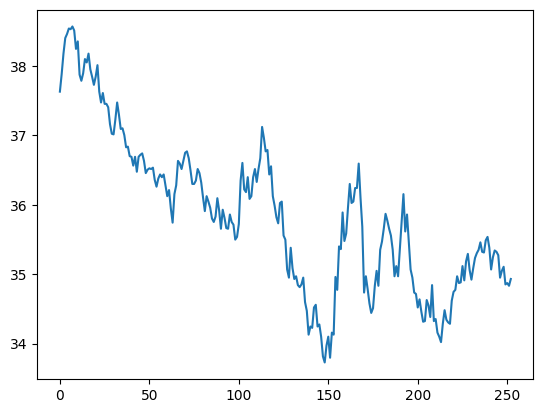

In [88]:
dem["czk"].plot()

In [27]:
dem["date"] = pd.to_datetime(dem["date"], format="%d.%m.%Y").dt.date

In [28]:
czk_full = pd.concat([dem[["date", "czk"]], czk], axis=0)

In [29]:
czk_full

,date,czk
0,1998-01-02,37.630169
1,1998-01-05,37.884427
2,1998-01-06,38.177802
3,1998-01-07,38.402722
4,1998-01-08,38.461397
...,...,...
6701,2024-12-03,25.224000
6702,2024-12-04,25.196000
6703,2024-12-05,25.146000
6704,2024-12-06,25.110000


In [30]:
czk_full["d_czk"] = czk_full["czk"].diff()

In [31]:
czk_full["date"] = pd.to_datetime(czk_full["date"])

In [32]:
czk_full = czk_full[czk_full["date"] >= "1998-01-01"].reset_index(drop=True)

In [33]:
czk_full.head()

,date,czk,d_czk
0,1998-01-02,37.630169,NaN
1,1998-01-05,37.884427,0.254258
2,1998-01-06,38.177802,0.293374
3,1998-01-07,38.402722,0.224920
4,1998-01-08,38.461397,0.058675


### Percentage deviation of real GDP from its trend

In [34]:
gdp = pd.read_csv("../../data/gdp_quaterly.csv", sep=";")

In [35]:
gdp = gdp.drop('Unnamed: 2', axis=1)

In [36]:
gdp.columns = ["date", "quaterly_gdp"]

In [37]:
gdp["date"] = pd.to_datetime(gdp["date"])

In [38]:
gdp = gdp.sort_values(by="date").reset_index(drop=True)

In [39]:
gdp_cycle, gdp_trend = hpfilter(gdp["quaterly_gdp"], lamb=1600)

In [40]:
gdp["trend"] = gdp_trend

In [41]:
def percentage_diff(x, y):
    return 100 * (x - y) / y

In [42]:
gdp["y"] = percentage_diff(gdp["quaterly_gdp"], gdp["trend"])

In [43]:
gdp["d_y"] = gdp["y"].diff()

In [44]:
gdp.head()

,date,quaterly_gdp,trend,y,d_y
0,1996-03-31,865698,855673.783775,1.171500,NaN
1,1996-06-30,870935,857073.946720,1.617253,0.445753
2,1996-09-30,875915,858480.374801,2.030871,0.413618
3,1996-12-31,875972,859907.996309,1.868107,-0.162763
4,1997-03-31,870901,861382.636181,1.105010,-0.763097


## 3. Merge dataframes and export finished dataframe as csv

### Preprocessing functions

In [45]:
'''
def bin(x):
    if x > 0.5:
        return 4
    elif 0 < x <= 0.5:
        return 3
    elif -0.5 <= x < 0:
        return 1
    elif x < -0.5:
        return 0
    else:
        return 2
'''

'\ndef bin(x):\n    if x > 0.5:\n        return 4\n    elif 0 < x <= 0.5:\n        return 3\n    elif -0.5 <= x < 0:\n        return 1\n    elif x < -0.5:\n        return 0\n    else:\n        return 2\n'

In [46]:
def bin_1(x):
    if x > 0:
        return 2
    elif x < 0:
        return 0
    else:
        return 1

In [47]:

def bin(x):
    if x > 1:
        return 4
    elif 0 < x <= 1:
        return 3
    elif x == 0:
        return 2
    elif -1 < x < 0:
        return 1
    else:
        return 0


In [48]:
def Normalize(x):
    return ((x - x.min()) / (x.max() - x.min()))

In [49]:
def Standardize(x):
    return (x - x.mean()) / x.std()

### Merge dataframes

In [50]:
sentiment_gdp = pd.merge_asof(
    sentiments, 
    gdp, 
    on="date", 
    direction="backward",
    tolerance=pd.Timedelta(weeks=96)
)

In [51]:
# Possibly change to direction="forward"!!
sgrr = pd.merge_asof(
    sentiment_gdp, 
    repo_rate, 
    on="date", 
    direction="forward",
    tolerance=pd.Timedelta(days=7)
)

In [52]:
sgrr = sgrr.fillna(0)

In [53]:
sgrr["d_r_cat_new"] = sgrr["d_r"].apply(lambda x: bin_1(x))

In [54]:
sgrr["d_r_cat"] = sgrr["d_r"].apply(lambda x: bin(x))

In [55]:
sgrr_czk = pd.merge_asof(
    sgrr, 
    czk_full, 
    on="date", 
    direction="forward",
    tolerance=pd.Timedelta(days=3)
)

In [56]:
data = pd.merge_asof(
    sgrr_czk,
    inflation,
    on="date",
    direction="nearest",
    tolerance=pd.Timedelta(days=16)
)

In [57]:
data["net_hawk_norm"] = Normalize(data["net_hawk"])

In [58]:
data.loc[:, "d_r_stan"] = Standardize(data["d_r"])

In [59]:
data.loc[:, "net_hawk_stan"] = Standardize(data["net_hawk"])

In [60]:
data["net_hawk_bert_stan"] = Standardize(data["net_hawk_bert"])

In [61]:
data.columns

Index(['date', 'sentiment', 'net_hawk', 'net_hawk_bert', 'quaterly_gdp',
       'trend', 'y', 'd_y', 'r', 'd_r', 'd_r_cat_new', 'd_r_cat', 'czk',
       'd_czk', 'hicp', 'd_hicp', 'net_hawk_norm', 'd_r_stan', 'net_hawk_stan',
       'net_hawk_bert_stan'],
      dtype='object')

In [62]:
new_column_order = ['date', 'sentiment', 'net_hawk', 'net_hawk_norm', 'net_hawk_stan', 'net_hawk_bert','net_hawk_bert_stan', 'r',
       'd_r', 'd_r_cat', 'd_r_cat_new', 'hicp', 'd_hicp','y', 'd_y', 'czk', 'd_czk']

In [63]:
data = data[new_column_order]

In [64]:
data = data.dropna(axis=0)

In [65]:
data.head()

,date,sentiment,net_hawk,net_hawk_norm,net_hawk_stan,net_hawk_bert,net_hawk_bert_stan,r,d_r,d_r_cat,d_r_cat_new,hicp,d_hicp,y,d_y,czk,d_czk
0,1998-01-22,neutral,-0.836015,0.317285,-1.033886,-0.661496,-0.741988,0.0,0.00,2,1,12.1,2.7,-0.525706,-0.542201,38.099568,0.205362
1,1998-02-19,neutral,0.188282,0.536305,0.092121,0.565248,0.663627,0.0,0.00,2,1,12.4,0.3,-0.525706,-0.542201,37.092316,-0.205362
2,1998-03-19,neutral,1.333873,0.781260,1.351467,0.666434,0.779567,15.0,0.25,3,2,12.4,0.0,-0.525706,-0.542201,36.261088,-0.097791
3,1998-04-30,hawkish,0.291455,0.558366,0.205539,0.161610,0.201135,0.0,0.00,2,1,12.0,-0.4,-0.858134,-0.332427,36.045947,-0.078233
4,1998-05-28,neutral,0.295797,0.559294,0.210312,0.342496,0.408396,0.0,0.00,2,1,12.0,0.0,-0.858134,-0.332427,36.349101,0.625866


In [66]:
data.to_csv("../../data/reg_data_cz.csv", index=False)

In [67]:
data["net_hawk_m1_p1"] = 2 * ((data["net_hawk"] - data["net_hawk"].min()) / (data["net_hawk"].max() - data["net_hawk"].min())) - 1

In [72]:
stata_data = pd.DataFrame({
    "PolChange_t1": data["d_r_cat_new"][1:].reset_index(drop=True),
    "PolChange_t": data["d_r_cat_new"][:-1].reset_index(drop=True),
    "NetHawk_stan": data["net_hawk_stan"][:-1].reset_index(drop=True),
    "NetHawk_bert": data["net_hawk_bert"][:-1].reset_index(drop=True),
    "NetHawk_bert_stan": data["net_hawk_bert_stan"][:-1].reset_index(drop=True),
    "sentiment": data["sentiment"][:-1].reset_index(drop=True),
    "dInf": data["d_hicp"][:-1].reset_index(drop=True),
    "dY": data["d_y"][:-1].reset_index(drop=True),
    "CZK": data["czk"][:-1].reset_index(drop=True),
})

In [73]:
stata_data.to_stata("../../data/stata_data.dta")

In [82]:
gdp

,date,quaterly_gdp,trend,y,d_y
0,1996-03-31,865698,8.556738e+05,1.171500,NaN
1,1996-06-30,870935,8.570739e+05,1.617253,0.445753
2,1996-09-30,875915,8.584804e+05,2.030871,0.413618
3,1996-12-31,875972,8.599080e+05,1.868107,-0.162763
4,1997-03-31,870901,8.613826e+05,1.105010,-0.763097
...,...,...,...,...,...
109,2023-06-30,1561483,1.560028e+06,0.093239,-0.127130
110,2023-09-30,1555623,1.564099e+06,-0.541932,-0.635171
111,2023-12-31,1559975,1.568148e+06,-0.521210,0.020722
112,2024-03-31,1565702,1.572187e+06,-0.412512,0.108697


<Axes: >

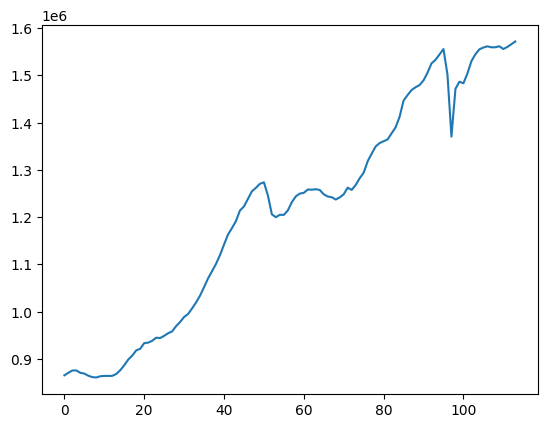

In [87]:
gdp["quaterly_gdp"].plot()